#**FOOLING SYNTH DETECTOR: CAN YOU SPOT THIS?**

Project by Nicola Busato (matr. 2119291) and Jacopo Momesso (matr. 2123874)

####Download GitHub's project (GAN Image Detector) and weights

In [ ]:
# Downloading the github project (GAN Image Detector) and respective weights
! git clone https://github.com/grip-unina/GANimageDetection.git
! wget -e robots=off -nd -P ./weights -A .pth -r https://www.grip.unina.it/download/prog/GANdetection/weights

Cloning into 'GANimageDetection'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 52 (delta 13), reused 51 (delta 13), pack-reused 0
Receiving objects: 100% (52/52), 1.32 MiB | 922.00 KiB/s, done.
Resolving deltas: 100% (13/13), done.
--2024-02-13 18:11:49--  https://www.grip.unina.it/download/prog/GANdetection/weights
Resolving www.grip.unina.it (www.grip.unina.it)... 143.225.28.237
Connecting to www.grip.unina.it (www.grip.unina.it)|143.225.28.237|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://www.grip.unina.it/download/prog/GANdetection/weights/ [following]
URL transformed to HTTPS due to an HSTS policy
--2024-02-13 18:11:51--  https://www.grip.unina.it/download/prog/GANdetection/weights/
Reusing existing connection to www.grip.unina.it:443.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘.

####Download CycleGAN

In [ ]:
! git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
! cd pytorch-CycleGAN-and-pix2pix

! bash /content/pytorch-CycleGAN-and-pix2pix/scripts/download_cyclegan_model.sh horse2zebra

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513
Receiving objects: 100% (2513/2513), 8.20 MiB | 16.08 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Note: available models are apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower
Specified [horse2zebra]
for details.

--2024-02-13 18:12:30--  http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models/horse2zebra.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45575747 (43M)
Saving t

####Import Horse2Zebra dataset from kaggle

In [ ]:
%%capture
# API kaggle
! pip install kaggle
! mkdir ~/.kaggle
! echo '{"username":"nicolab01","key":"1ae845d62ec743cb0301d3365ac4f753"}' > kaggle.json
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Download and unzip dataset
! kaggle datasets download balraj98/horse2zebra-dataset

# Make same directories and unzip
! mkdir horse2zebra
! mkdir few_horse2zebra
! mkdir processed_img

! unzip horse2zebra-dataset -d horse2zebra

####Using CycleGAN to create fake image

In [ ]:
! pip install dominate
! pip install wandb

# Create fake zebra images
! python /content/pytorch-CycleGAN-and-pix2pix/test.py --dataroot /content/horse2zebra/trainA --name horse2zebra_pretrained --model test --no_dropout --results_dir /content/our_horse2zebra --num_test 1067
! python /content/pytorch-CycleGAN-and-pix2pix/test.py --dataroot /content/horse2zebra/testA --name horse2zebra_pretrained --model test --no_dropout --results_dir /content/our_horse2zebra --num_test 120

# Clean directory
! mv /content/our_horse2zebra/horse2zebra_pretrained/test_latest/images/*fake.png /content/our_horse2zebra
! rm -r /content/our_horse2zebra/horse2zebra_pretrained/

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.7 MB/s eta 0:00:00
----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/horse2zebra/trainA   	[default: None]
             dataset_mode: single                        
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0         

In [ ]:
# Total number of images created
! ls /content/our_horse2zebra | wc -l

1187


## IMPORT OF THE LIBRARIES

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import glob
import os
import numpy as np
import cv2 as cv
import pandas as pd
import subprocess
import shutil

from PIL import Image

##HELPER FUNCTIONS
We have defined some helper functions for the operations we want to perform

In [ ]:
def copyImages(source_directory, destination_directory, n):
    """
    Copy the first n images from the source directory to the destination directory.

    Args:
    - source_directory (str): Path of the source directory.
    - destination_directory (str): Path of the destination directory.
    - n (int): Number of images to copy.

    Returns:
    - None
    """

    # Copy only the first n images an
    for i in range(n):
        name = f"{i+1:04d}.jpg"
        source_file_path = os.path.join(source_directory, name)
        destination_file_path = os.path.join(destination_directory, name)
        shutil.copy(source_file_path, destination_file_path)

In [ ]:
def preprocess(image):
  """
  Preprocesses an image to meet the requirements of MobileNetV2.
  MobileNetV2 expects preprocessed images with the following specifications:
  - Image should be of data type tf.float32.
  - Image should be resized to max (224, 224) pixels.
  - Image should be preprocessed using the MobileNetV2 preprocess_input function.
  - Image should have an additional dimension added to represent the batch size (batch size of 1).

  Args:
      image: Input image.

  Returns:
      tf.Tensor: Preprocessed image tensor suitable for MobileNetV2.
  """

  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (224, 224))
  # preprocess_input function performs normalization and scaling of the input image
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
  image = image[None, ...]
  return image

In [ ]:
# variable that stores the directory in the workspace
image_directory = []

# process image directory output
PROCESS_IMAGES_DIR = "processed_img/"

def createDirectory(directory, add_to_array = True):
  """
  Creates a directory using the 'mkdir' command and optionally adds it to the global array image_directory.

  Args:
      directory: Directory path to be created.
      add_to_array (bool): Flag indicating whether to add the directory to a global array. Default is True.

  Returns:
      None
  """

  command = [
      "mkdir",
      directory
      ]
  subprocess.run(command)

  # Adds the directory in the array if add_to_array = True and if the directory path still does not exist
  if add_to_array and (directory not in image_directory):
    image_directory.append(directory)

In [ ]:
def printImg(image):
  """
  Displays an image

  Args:
      image: Input image.

  Returns:
      None
  """

  plt.figure()
  plt.imshow(image)
  plt.axis('off')  # hide axis
  plt.show()

In [ ]:
def plotImages(images, rows, cols):
  """
  Plot a grid of images.

  Args:
      images (list of arrays): List of images to be plotted.
      rows (int): Number of rows in the grid.
      cols (int): Number of columns in the grid.

  Returns:
      None
  """

  fig, axes = plt.subplots(rows, cols, figsize=(cols, rows))
  for i, ax in enumerate(axes.flat):
      ax.imshow(images[i])
      ax.set_xticks([])
      ax.set_yticks([])
  plt.tight_layout()
  plt.show()

In [ ]:
# Define a common extension
EXTENSION = ".jpg"

def saveAsImg(img, directory, name, is_numpy_array = True):
  """
  Saves an image to a specified directory with a given name

  Args:
    img: Input image.
    directory (str): Directory path where the image will be saved.
    name (str): Name of the image file (excluding extension).
    is_numpy_array (bool): Flag indicating whether 'img' is a NumPy array (True) or a PIL Image (False). Default is True.

  Returns:
    None
  """

  # If 'is_numpy_array' is True, it normalizes the image in order to fit values between 0 and 255
  if is_numpy_array:
    img = (np.clip(img, 0, 1) * 255).astype(np.uint8)

  # Creates a RGB image object from Numpy array
  img = Image.fromarray(img, 'RGB')

  # Create the specified directory if it does not exist and then saves the image
  createDirectory(directory + "/")
  img.save(directory + "/" + name + EXTENSION)

Use of [MobileNetV2](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/applications/MobileNetV2)

In [ ]:
# Loading and setting the pre-trained model MobileNetV2
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False

# Define the categorical crossentropy loss
loss_object = tf.keras.losses.CategoricalCrossentropy()

def createAdversarialPattern(input_image):
  """
  Creates an adversarial pattern for a given input image.
  The function uses a GradientTape to compute the gradients of the model's prediction confidence
  with respect to the input image.

  Args:
    input_image: Input image for which the adversarial pattern will be created.

  Returns:
    tf.Tensor: Adversarial pattern tensor.
  """

  with tf.GradientTape() as tape:
    tape.watch(input_image)
    # Computes the prediction of pretrained_model of the input image
    prediction = pretrained_model(input_image)
    #compute the loss of the prediction of the model w.r.t. input_label
    #loss = loss_object(input_label, prediction)
    original_class_confidence = tf.reduce_max(prediction)

  # Get the gradients of the loss w.r.t to the input image.
  #gradient = tape.gradient(loss, input_image)
  gradient = tape.gradient(original_class_confidence, input_image)
  # Get the sign of the gradients to create the perturbation
  signed_grad = tf.sign(gradient)

  return signed_grad

14536120/14536120 [==============================] - 2s 0us/step


In [ ]:
def adversarialNoise(filename, dir_output, epsilons = [0.05]):
  """
  Generates adversarial noise for a given image and saves the perturbed images
  with varying epsilon values in separate directories.

  Args:
      filename (str): Path to the input image file.
      dir_output (str): Directory where the perturbed images will be saved.
      epsilons (list): List of epsilon values for adversarial perturbations. Default is [0.05].

  Returns:
      None
  """

  # If dir_output is not set, we define it
  if dir_output == "" :
    dir_output = "adversarialNoise"
  dir_output = PROCESS_IMAGES_DIR + dir_output

  image_raw = tf.io.read_file(filename)
  image = tf.image.decode_image(image_raw)

  # Preprocess the image and create adversarial perturbations
  image = preprocess(image)
  perturbations = createAdversarialPattern(image)

  for eps in epsilons:
    print("  Added adversarial noise, eps = " + "{:.3f}".format(eps))
    # Computes the adversarial sample
    adv_x = image + eps * perturbations
    # Clips the adversarial sample to make sure that its values are still in the correct range
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    saveAsImg(adv_x[0]*0.5+0.5, dir_output + "_" + "{:.3f}".format(eps).replace('.','_'), filename.split("/")[-1].split(".")[0])

In [ ]:
def randomNoise(filename, dir_output, noise_scale=[25]):
  """
  Add random Gaussian noise to a given image and saves it.
  Noisy images are saved with varying noise scale values in separate directories.

  Args:
    filename (str): Path to the input image file.
    name (str): Name of the output files (without extension).
    noise_scale (list): List of noise scale values for random noise. Default is [25].

  Returns:
    None
  """

  # If dir_output is not set, we define it
  if dir_output == "" :
    dir_output = "randomNoise"
  dir_output = PROCESS_IMAGES_DIR + dir_output

  # Loads the image
  img = cv.imread(filename)
  img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

  # Converts OpenCV image to TensorFlow tensor
  img_tensor = tf.convert_to_tensor(img_rgb, dtype=tf.float32)

  # Generates random noise using TensorFlow
  random_noise = tf.random.normal(shape=tf.shape(img_rgb), mean=0.0, stddev=1.0)

  for noise_lv in noise_scale:
    print("  Added random noise, noise level: " + str(noise_lv))
    # Adds the noise to the image tensor
    noisy_image_tensor = img_tensor + noise_lv * random_noise

    # Clips values to stay within the valid range for display
    noisy_image_tensor = tf.clip_by_value(noisy_image_tensor, 0.0, 255.0)

    # Converts TensorFlow tensor back to numpy array for display
    saveAsImg(noisy_image_tensor.numpy().astype(np.uint8), dir_output + "_" + "{:03d}".format(noise_lv), filename.split("/")[-1].split(".")[0], False)

In [ ]:
def imageManipulation(filename, dir_output):
  """
  Applies image manipulation techniques and saves the manipulated image.

  Args:
    filename (str): Path to the input image file.
    name (str): Name of the output file (without extension).
    dir_output (str): Directory path where the manipulated image will be saved. Default is "manipulated/".

  Returns:
    None
  """

  # If dir_output is not set, we define it
  if dir_output == "" :
    dir_output = "manipulated"
  dir_output = PROCESS_IMAGES_DIR + dir_output

  print("  Do manipulation")
  # Loads the image using cv2
  img = cv.imread(filename)
  img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
  rows, cols, _ = img_rgb.shape

  # Shearing transformation
  M = np.float32([[1, 0.1, -10], [0.1, 1, -10], [0, 0, 1]])
  sheared_img = cv.warpPerspective(img_rgb, M, (int(cols*1.1), int(rows*1.1)))

  # Rotation transformation
  angle = 6
  rotation_matrix = cv.getRotationMatrix2D((cols / 2, rows / 2), angle, 1.1)
  rotated_img = cv.warpAffine(sheared_img, rotation_matrix, (cols, rows))

  # Saves the manipulated image
  saveAsImg(rotated_img, dir_output, filename.split("/")[-1].split(".")[0], False)

In [ ]:
def RunGANimageDetection(directory):
  """
  Run GANimageDetector on images in a specified directory and save the output.

  Args:
      directory (str): Directory path containing images for detection.

  Returns:
      None
  """

  createDirectory("detectorOutput", False) # Directory with all detectior output
  print("Start detection of directory: " + directory)

  # Command to run the GANimageDetector
  directory_out = directory[:-1].split("/")[-1]
  command = [
    'python',
    '/content/GANimageDetection/main.py',
    '-m',
    'weights/gandetection_resnet50nodown_stylegan2.pth',
    '-i',
    './' + directory,
    '-o',
    "detectorOutput/" + directory_out + '_out.csv'
    ]

  # Runs the command
  subprocess.run(command)

In [ ]:
def CSV_stamp(directory):
  """
  Prints and processes CSV data from a directory.

  Args:
      directory (str): The directory containing CSV files.

  Returns:
      float: The mean confidence value from the data (logit).
      float: The minimum confidence value from the data (logit).
      float: The maximum confidence value from the data (logit).
  """

  print("Results of directory: " + directory)
  directory_out = directory[:-1].replace(PROCESS_IMAGES_DIR, "")
  output = "detectorOutput/" + directory_out + "_out.csv"

  # Read csv file
  data = pd.read_csv(output)

  data['filename'] = data['filename'].str.split('/').str[-1] # Stamp only filename without dir
  data.drop(columns=data.columns[-1], inplace=True) # Remove time column

  # Add a column that says if the image is classified as real or fake.
  def label_fake(value):
    return "Fake" if value > 0 else "Real"
  data['Classified'] = data.iloc[:, 1].apply(label_fake)

  # Rename comumns
  data = data.rename(columns={'filename': 'Filename', 'logit': 'Confidence'})

  # Print the data
  print(data.to_string(index=False, line_width=200, justify='center', col_space=15, na_rep=''))

  # Count the number and percentage of misclassified images.
  num_negatives = (data.iloc[:, 1] < 0).sum()
  percentage_misclassified = (num_negatives / len(data)) * 100
  print(f"\nElement misclassified: {num_negatives} ({percentage_misclassified:.2f}%)")

  # Return the mean, min and max confidence value
  return data.iloc[:, 1].mean(), data.iloc[:, 1].min(), data.iloc[:, 1].max()

In [ ]:
# Method type
ADVERSARIAL_NOISE = 0
RANDOM_NOISE = 1
IMAGE_MANIPULATION = 2

def processImages(method, input_dir, output_dir = "", args = None):
  """
  Process images based on the specified method.

  Args:
  - method (int): Method type to apply to the images:
    - ADVERSARIAL_NOISE (0): Apply adversarial noise to the images.
    - RANDOM_NOISE (1): Apply random noise to the images.
    - IMAGE_MANIPULATION (2): Apply image manipulation techniques to the images.
  - input_dir (str): Directory path containing input images.
  - output_dir (str): Directory path where processed images will be saved. Default is an empty string.
  - args (list): Additional arguments depending on the chosen method.
    - For ADVERSARIAL_NOISE, provide a list of epsilon values.
    - For RANDOM_NOISE, provide a list of noise scale values.
    - IMAGE_MANIPULATION does not require additional arguments.

  Returns:
  - None
  """

  list_files = sorted(sum([glob.glob(os.path.join(input_dir,'*.'+x)) for x in ['jpg','JPG','jpeg','JPEG','png','PNG']], list()))

  # Use all input images in the directory in list_files
  for filename in list_files:
    print(filename.split("/")[-1].split(".")[0])

    # Adding Adversarial Noise
    if method == ADVERSARIAL_NOISE:
      adversarialNoise(filename, output_dir, epsilons = args)

    # Adding Random Noise
    elif method == RANDOM_NOISE:
      randomNoise(filename, output_dir, noise_scale = args)

    # Manipulating the image
    elif method == IMAGE_MANIPULATION:
      imageManipulation(filename, output_dir)

In [ ]:
def plot_accuracy(x, y, y_min, y_max, label, x_label=""):
    """
    Plots the accuracy graph.

    Args:
        x (list or array-like): X-axis values.
        y (list or array-like): Y-axis values.
        y_min (list or array-like): Minimum y-axis values for each x.
        y_max (list or array-like): Maximum y-axis values for each x.
        label (str): Label for the plot.
        x_label (list or array-like, optional): Labels for x-axis ticks.

    Returns:
        None
    """

    plt.figure(figsize=(6, 4))
    plt.errorbar(x, y, yerr=[np.array(y) - np.array(y_min), np.array(y_max) - np.array(y)], fmt='o', ls='-', label=label)
    plt.ylabel('Confidence')
    plt.grid(True)

    if x_label:
        plt.xticks(x, x_label)  # Explicitly set x-axis labels
        plt.title(f'Classification with different strategies')
    else:
        plt.xticks(np.arange(x.min(), x.max() + 0.01, (x.max() - x.min()) / 10))
        plt.title(f'Classification with different levels of {label} noise')
        plt.xlabel('Epsilon')

    plt.axhline(y=0, color='r', linestyle=':', label='Classification Threshold')
    # plt.legend(loc='upper right')
    plt.show()

##GENERATE SUBSET OF IMAGES
Since we have 1187 generated images, we decided to select only 15% of them (178) to speed up the execution

In [ ]:
source_directory = "/content/our_horse2zebra"
destination_directory = "/content/few_horse2zebra"
total_elements = len(glob.glob(source_directory + '/*')) # Number of elements

percentage_elements = 0.15 # 15% of the elements to use to find the best fooling strategy.
elements = int(total_elements*percentage_elements)

# Rename the images
for idx, filename in enumerate(os.listdir(source_directory), start=1):
    new_name = f"{idx:04d}.jpg"
    os.rename(os.path.join(source_directory, filename), os.path.join(source_directory, new_name))

print(f"Elements used to find the best strategy {elements} out of {total_elements} ({percentage_elements*100:.0f}%)")

copyImages(source_directory, destination_directory, elements)

Elements used to find the best strategy 178 out of 1187 (15%)


##**CREATE FOOLING IMAGES**
Use of the deception strategies defined above

In [ ]:
# Adversarial noise strategy
adv_epsilon = np.arange(0, 0.105, 0.005) # From 0 to 0.1 in steps of 0.005
processImages(ADVERSARIAL_NOISE,
               "few_horse2zebra",
                args = adv_epsilon)

0001
  Added adversarial noise, eps = 0.000
  Added adversarial noise, eps = 0.005
  Added adversarial noise, eps = 0.010
  Added adversarial noise, eps = 0.015
  Added adversarial noise, eps = 0.020
  Added adversarial noise, eps = 0.025
  Added adversarial noise, eps = 0.030
  Added adversarial noise, eps = 0.035
  Added adversarial noise, eps = 0.040
  Added adversarial noise, eps = 0.045
  Added adversarial noise, eps = 0.050
  Added adversarial noise, eps = 0.055
  Added adversarial noise, eps = 0.060
  Added adversarial noise, eps = 0.065
  Added adversarial noise, eps = 0.070
  Added adversarial noise, eps = 0.075
  Added adversarial noise, eps = 0.080
  Added adversarial noise, eps = 0.085
  Added adversarial noise, eps = 0.090
  Added adversarial noise, eps = 0.095
  Added adversarial noise, eps = 0.100
0002
  Added adversarial noise, eps = 0.000
  Added adversarial noise, eps = 0.005
  Added adversarial noise, eps = 0.010
  Added adversarial noise, eps = 0.015
  Added adversa

In [ ]:
# Random noise strategy
random_epsilon = np.arange(0, 105, 5) # From 0 to 100 in steps of 5
processImages(RANDOM_NOISE,
              "few_horse2zebra",
              args = random_epsilon)

0001
  Added random noise, noise level: 0
  Added random noise, noise level: 5
  Added random noise, noise level: 10
  Added random noise, noise level: 15
  Added random noise, noise level: 20
  Added random noise, noise level: 25
  Added random noise, noise level: 30
  Added random noise, noise level: 35
  Added random noise, noise level: 40
  Added random noise, noise level: 45
  Added random noise, noise level: 50
  Added random noise, noise level: 55
  Added random noise, noise level: 60
  Added random noise, noise level: 65
  Added random noise, noise level: 70
  Added random noise, noise level: 75
  Added random noise, noise level: 80
  Added random noise, noise level: 85
  Added random noise, noise level: 90
  Added random noise, noise level: 95
  Added random noise, noise level: 100
0002
  Added random noise, noise level: 0
  Added random noise, noise level: 5
  Added random noise, noise level: 10
  Added random noise, noise level: 15
  Added random noise, noise level: 20
  Add

In [ ]:
# Image manipulation strategy
processImages(IMAGE_MANIPULATION,
              "few_horse2zebra")

0001
  Do manipulation
0002
  Do manipulation
0003
  Do manipulation
0004
  Do manipulation
0005
  Do manipulation
0006
  Do manipulation
0007
  Do manipulation
0008
  Do manipulation
0009
  Do manipulation
0010
  Do manipulation
0011
  Do manipulation
0012
  Do manipulation
0013
  Do manipulation
0014
  Do manipulation
0015
  Do manipulation
0016
  Do manipulation
0017
  Do manipulation
0018
  Do manipulation
0019
  Do manipulation
0020
  Do manipulation
0021
  Do manipulation
0022
  Do manipulation
0023
  Do manipulation
0024
  Do manipulation
0025
  Do manipulation
0026
  Do manipulation
0027
  Do manipulation
0028
  Do manipulation
0029
  Do manipulation
0030
  Do manipulation
0031
  Do manipulation
0032
  Do manipulation
0033
  Do manipulation
0034
  Do manipulation
0035
  Do manipulation
0036
  Do manipulation
0037
  Do manipulation
0038
  Do manipulation
0039
  Do manipulation
0040
  Do manipulation
0041
  Do manipulation
0042
  Do manipulation
0043
  Do manipulation
0044
  Do m

In [ ]:
# combine strategy, add adversarialNoise to manipulated images
processImages(ADVERSARIAL_NOISE,
              PROCESS_IMAGES_DIR + "manipulated", # Get manipulated image
              output_dir = "manipulated_adversarialNoise",
              args = [0.03])

0001
  Added adversarial noise, eps = 0.030
0002
  Added adversarial noise, eps = 0.030
0003
  Added adversarial noise, eps = 0.030
0004
  Added adversarial noise, eps = 0.030
0005
  Added adversarial noise, eps = 0.030
0006
  Added adversarial noise, eps = 0.030
0007
  Added adversarial noise, eps = 0.030
0008
  Added adversarial noise, eps = 0.030
0009
  Added adversarial noise, eps = 0.030
0010
  Added adversarial noise, eps = 0.030
0011
  Added adversarial noise, eps = 0.030
0012
  Added adversarial noise, eps = 0.030
0013
  Added adversarial noise, eps = 0.030
0014
  Added adversarial noise, eps = 0.030
0015
  Added adversarial noise, eps = 0.030
0016
  Added adversarial noise, eps = 0.030
0017
  Added adversarial noise, eps = 0.030
0018
  Added adversarial noise, eps = 0.030
0019
  Added adversarial noise, eps = 0.030
0020
  Added adversarial noise, eps = 0.030
0021
  Added adversarial noise, eps = 0.030
0022
  Added adversarial noise, eps = 0.030
0023
  Added adversarial noise, 

In [ ]:
# combine strategy, add randomNoise to manipulated images
processImages(RANDOM_NOISE,
              PROCESS_IMAGES_DIR + "manipulated", # Get manipulated image
              output_dir = "manipulated_randomNoise",
              args = [10])

0001
  Added random noise, noise level: 10
0002
  Added random noise, noise level: 10
0003
  Added random noise, noise level: 10
0004
  Added random noise, noise level: 10
0005
  Added random noise, noise level: 10
0006
  Added random noise, noise level: 10
0007
  Added random noise, noise level: 10
0008
  Added random noise, noise level: 10
0009
  Added random noise, noise level: 10
0010
  Added random noise, noise level: 10
0011
  Added random noise, noise level: 10
0012
  Added random noise, noise level: 10
0013
  Added random noise, noise level: 10
0014
  Added random noise, noise level: 10
0015
  Added random noise, noise level: 10
0016
  Added random noise, noise level: 10
0017
  Added random noise, noise level: 10
0018
  Added random noise, noise level: 10
0019
  Added random noise, noise level: 10
0020
  Added random noise, noise level: 10
0021
  Added random noise, noise level: 10
0022
  Added random noise, noise level: 10
0023
  Added random noise, noise level: 10
0024
  Adde

In [ ]:
# combine strategy, add adversarial noise to a randomNoise+manipulated images
processImages(ADVERSARIAL_NOISE,
              PROCESS_IMAGES_DIR + "manipulated_randomNoise_010", # Get manipulated+randomNoise image
              output_dir = "manipulated_randomNoise_010_adversarialNoise",
              args = [0.03])

0001
  Added adversarial noise, eps = 0.030
0002
  Added adversarial noise, eps = 0.030
0003
  Added adversarial noise, eps = 0.030
0004
  Added adversarial noise, eps = 0.030
0005
  Added adversarial noise, eps = 0.030
0006
  Added adversarial noise, eps = 0.030
0007
  Added adversarial noise, eps = 0.030
0008
  Added adversarial noise, eps = 0.030
0009
  Added adversarial noise, eps = 0.030
0010
  Added adversarial noise, eps = 0.030
0011
  Added adversarial noise, eps = 0.030
0012
  Added adversarial noise, eps = 0.030
0013
  Added adversarial noise, eps = 0.030
0014
  Added adversarial noise, eps = 0.030
0015
  Added adversarial noise, eps = 0.030
0016
  Added adversarial noise, eps = 0.030
0017
  Added adversarial noise, eps = 0.030
0018
  Added adversarial noise, eps = 0.030
0019
  Added adversarial noise, eps = 0.030
0020
  Added adversarial noise, eps = 0.030
0021
  Added adversarial noise, eps = 0.030
0022
  Added adversarial noise, eps = 0.030
0023
  Added adversarial noise, 

##IMAGE BEFORE MODIFICATION
Run the detector on the Cycle-GAN generated images and print the results

In [ ]:
# Run the Detector on the Cycle-GAN generated images
RunGANimageDetection("few_horse2zebra/")
CSV_stamp("few_horse2zebra/")

Start detection of directory: few_horse2zebra/
Results of directory: few_horse2zebra/
    Filename       Confidence      Classified  
    0001.jpg        8.363673          Fake     
    0002.jpg        3.990083          Fake     
    0003.jpg        6.838531          Fake     
    0004.jpg        6.091941          Fake     
    0005.jpg        4.158051          Fake     
    0006.jpg       11.905462          Fake     
    0007.jpg       -1.842393          Real     
    0008.jpg        6.214396          Fake     
    0009.jpg        4.015122          Fake     
    0010.jpg        6.275671          Fake     
    0011.jpg        6.324999          Fake     
    0012.jpg        4.878572          Fake     
    0013.jpg        4.766383          Fake     
    0014.jpg        3.711943          Fake     
    0015.jpg        3.929339          Fake     
    0016.jpg        7.608061          Fake     
    0017.jpg        2.138396          Fake     
    0018.jpg        6.478256          Fake     
  

(4.640951382022472, -1.842393, 12.325659)

##IMAGE AFTER MODIFICATION
Run the detector on the modified Cycle-GAN generated images and print the accuracy

In [ ]:
# Save output
advNoiseMean, advNoiseMin, advNoiseMax = [], [], []
rndNoiseMean, rndNoiseMin, rndNoiseMax = [], [], []
manipMean, manipMin, manipMax = [], [], []

# Run the Detector on the directories
for image_path in image_directory:
    RunGANimageDetection(image_path)
    mean, min, max = CSV_stamp(image_path)
    if("/adversarialNoise_" in image_path):
      advNoiseMean.append(mean)
      advNoiseMin.append(min)
      advNoiseMax.append(max)
    if("/randomNoise_" in image_path):
      rndNoiseMean.append(mean)
      rndNoiseMin.append(min)
      rndNoiseMax.append(max)
    if("/manipulated" in image_path):
      manipMean.append(mean)
      manipMin.append(min)
      manipMax.append(max)
    print()

Streaming output truncated to the last 5000 lines.
    0150.jpg        -9.574740         Real     
    0151.jpg       -13.580981         Real     
    0152.jpg       -19.264433         Real     
    0153.jpg       -10.050674         Real     
    0154.jpg        -8.418346         Real     
    0155.jpg        -9.613811         Real     
    0156.jpg       -14.586589         Real     
    0157.jpg       -14.181342         Real     
    0158.jpg       -13.008175         Real     
    0159.jpg       -10.899386         Real     
    0160.jpg       -11.915739         Real     
    0161.jpg       -10.442791         Real     
    0162.jpg       -12.388608         Real     
    0163.jpg       -18.034838         Real     
    0164.jpg       -10.233670         Real     
    0165.jpg        -9.890086         Real     
    0166.jpg       -10.046529         Real     
    0167.jpg       -10.301679         Real     
    0168.jpg        -7.612405         Real     
    0169.jpg        -4.586031        

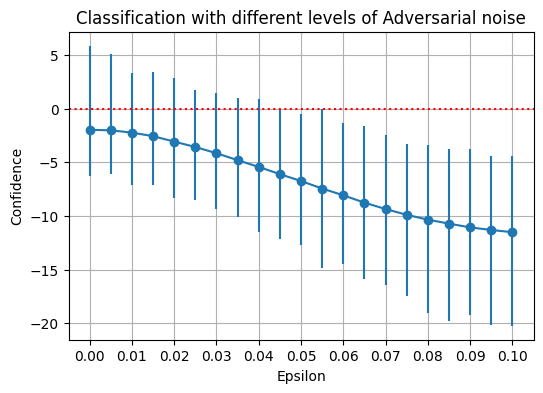

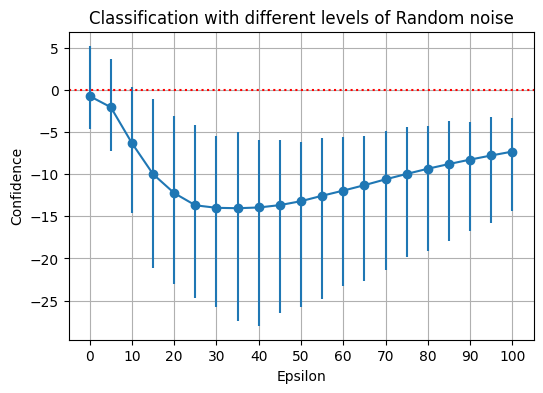

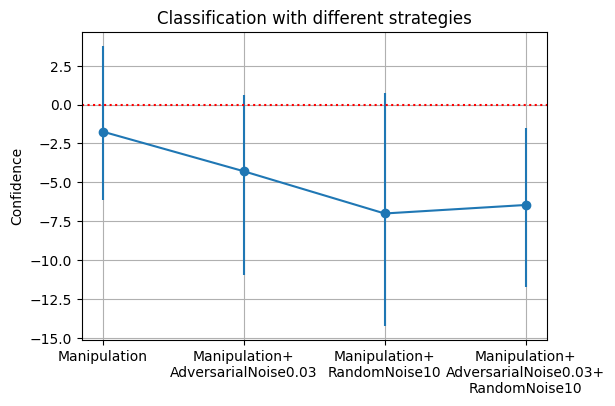

In [ ]:
plot_accuracy(adv_epsilon, advNoiseMean, advNoiseMin, advNoiseMax, "Adversarial")
print()
plot_accuracy(random_epsilon, rndNoiseMean, rndNoiseMin, rndNoiseMax, "Random")
print()
plot_accuracy(np.array([1, 2, 3, 4]), manipMean, manipMin, manipMax, "Other Strategy", x_label=["Manipulation", "Manipulation+\nAdversarialNoise0.03", "Manipulation+\nRandomNoise10", "Manipulation+\nAdversarialNoise0.03+\nRandomNoise10"])


##SELECTION OF THE BEST STRATEGIY
We must select a subset of strategies and a larger subset so that we can choose the best strategy to fool the detector.

By having a smaller number of strategies to test and enlarging the dataset we can have a larger set of images on which to base our decision as to the best.

Strategy to keep from so we look for the best one:
*   Adversarial Noise with eps: 0.06 (it's less closer to 0)
*   Random Noise with eps: 17 (middle ground between 15 and 20)
*   Manipulation + AdversarialNoise 0.04 + RandomNoise 10 (increase from 0.03 to 0.04)



In [ ]:
# Since we have selected the best strategy, we can now use a bigger set of images
percentage_elements = 0.60 # 60%
elements = int(total_elements*percentage_elements)
copyImages(source_directory, destination_directory, elements) # add image to few_horse2zebra dir
print(f"Elements used to find the best strategy {elements} out of {total_elements} ({percentage_elements*100:.0f}%)")

Elements used to find the best strategy 712 out of 1187 (60%)


In [ ]:
bestStrategy = []
processImages(ADVERSARIAL_NOISE,
              "few_horse2zebra",
              output_dir = "bestStrategy_adversarialNoise",
              args = [0.06])

bestStrategy.append(PROCESS_IMAGES_DIR + "bestStrategy_adversarialNoise_0_060")

0001
  Added adversarial noise, eps = 0.060
0002
  Added adversarial noise, eps = 0.060
0003
  Added adversarial noise, eps = 0.060
0004
  Added adversarial noise, eps = 0.060
0005
  Added adversarial noise, eps = 0.060
0006
  Added adversarial noise, eps = 0.060
0007
  Added adversarial noise, eps = 0.060
0008
  Added adversarial noise, eps = 0.060
0009
  Added adversarial noise, eps = 0.060
0010
  Added adversarial noise, eps = 0.060
0011
  Added adversarial noise, eps = 0.060
0012
  Added adversarial noise, eps = 0.060
0013
  Added adversarial noise, eps = 0.060
0014
  Added adversarial noise, eps = 0.060
0015
  Added adversarial noise, eps = 0.060
0016
  Added adversarial noise, eps = 0.060
0017
  Added adversarial noise, eps = 0.060
0018
  Added adversarial noise, eps = 0.060
0019
  Added adversarial noise, eps = 0.060
0020
  Added adversarial noise, eps = 0.060
0021
  Added adversarial noise, eps = 0.060
0022
  Added adversarial noise, eps = 0.060
0023
  Added adversarial noise, 

In [ ]:
processImages(RANDOM_NOISE,
              "few_horse2zebra",
              output_dir = "bestStrategy_randomNoise",
              args = [17])

bestStrategy.append(PROCESS_IMAGES_DIR + "bestStrategy_randomNoise_017")

0001
  Added random noise, noise level: 17
0002
  Added random noise, noise level: 17
0003
  Added random noise, noise level: 17
0004
  Added random noise, noise level: 17
0005
  Added random noise, noise level: 17
0006
  Added random noise, noise level: 17
0007
  Added random noise, noise level: 17
0008
  Added random noise, noise level: 17
0009
  Added random noise, noise level: 17
0010
  Added random noise, noise level: 17
0011
  Added random noise, noise level: 17
0012
  Added random noise, noise level: 17
0013
  Added random noise, noise level: 17
0014
  Added random noise, noise level: 17
0015
  Added random noise, noise level: 17
0016
  Added random noise, noise level: 17
0017
  Added random noise, noise level: 17
0018
  Added random noise, noise level: 17
0019
  Added random noise, noise level: 17
0020
  Added random noise, noise level: 17
0021
  Added random noise, noise level: 17
0022
  Added random noise, noise level: 17
0023
  Added random noise, noise level: 17
0024
  Adde

In [ ]:
processImages(IMAGE_MANIPULATION,
              "few_horse2zebra",
               output_dir = "bestStrategy_manipulated")

processImages(RANDOM_NOISE,
              PROCESS_IMAGES_DIR + "bestStrategy_manipulated",
              output_dir = "bestStrategy_manipulated_randomNoise",
              args = [10])

processImages(ADVERSARIAL_NOISE,
              PROCESS_IMAGES_DIR + "bestStrategy_manipulated_randomNoise_010",
              output_dir = "bestStrategy_manipulated_randomNoise_010_adversarialNoise",
              args = [0.04])

bestStrategy.append(PROCESS_IMAGES_DIR + "bestStrategy_manipulated_randomNoise_010_adversarialNoise_0_040")

0001
  Do manipulation
0002
  Do manipulation
0003
  Do manipulation
0004
  Do manipulation
0005
  Do manipulation
0006
  Do manipulation
0007
  Do manipulation
0008
  Do manipulation
0009
  Do manipulation
0010
  Do manipulation
0011
  Do manipulation
0012
  Do manipulation
0013
  Do manipulation
0014
  Do manipulation
0015
  Do manipulation
0016
  Do manipulation
0017
  Do manipulation
0018
  Do manipulation
0019
  Do manipulation
0020
  Do manipulation
0021
  Do manipulation
0022
  Do manipulation
0023
  Do manipulation
0024
  Do manipulation
0025
  Do manipulation
0026
  Do manipulation
0027
  Do manipulation
0028
  Do manipulation
0029
  Do manipulation
0030
  Do manipulation
0031
  Do manipulation
0032
  Do manipulation
0033
  Do manipulation
0034
  Do manipulation
0035
  Do manipulation
0036
  Do manipulation
0037
  Do manipulation
0038
  Do manipulation
0039
  Do manipulation
0040
  Do manipulation
0041
  Do manipulation
0042
  Do manipulation
0043
  Do manipulation
0044
  Do m

### Post-edit

In [ ]:
bestMean = []
bestMin = []
bestMax = []

for strategy in bestStrategy:
    RunGANimageDetection(strategy)
    mean, min, max = CSV_stamp(strategy)
    bestMean.append(mean)
    bestMin.append(min)
    bestMax.append(max)
    print()

Start detection of directory: processed_img/bestStrategy_adversarialNoise_0_060
Results of directory: processed_img/bestStrategy_adversarialNoise_0_060
    Filename       Confidence      Classified  
    0001.jpg        -4.483397         Real     
    0002.jpg        -8.059530         Real     
    0003.jpg        -1.590328         Real     
    0004.jpg       -12.361359         Real     
    0005.jpg        -6.316136         Real     
    0006.jpg        -5.947468         Real     
    0007.jpg       -11.543880         Real     
    0008.jpg        -7.462901         Real     
    0009.jpg        -7.253198         Real     
    0010.jpg        -8.184013         Real     
    0011.jpg        -5.993883         Real     
    0012.jpg       -10.596828         Real     
    0013.jpg        -5.295036         Real     
    0014.jpg        -8.678344         Real     
    0015.jpg        -8.004218         Real     
    0016.jpg       -11.451949         Real     
    0017.jpg        -9.240740   

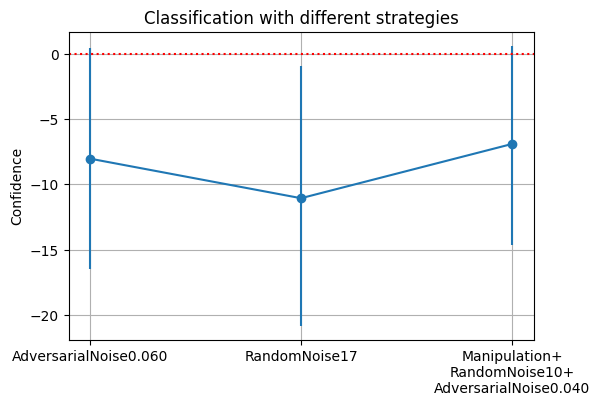

In [ ]:
plot_accuracy(np.array([1, 2, 3]), bestMean, bestMin, bestMax, "Best Strategy",
              x_label=["AdversarialNoise0.060",
                       "RandomNoise17",
                       "Manipulation+\nRandomNoise10+\nAdversarialNoise0.040"])

We decided to discard RandomNoise due to its excessive spread. Combining it with the third strategy isn't bad, but it's complicated to create and changes the image considerably. We therefore opted for AdversarialNoise, but with a higher epsilon value. At 0.055, it is too close to classify the elements as real.

Instead, we decided to use an epsilon of 0.065.

In [ ]:
processImages(ADVERSARIAL_NOISE,
              "our_horse2zebra",
              output_dir = "bestStrategy_adversarialNoise",
              args = [0.065])

0001
  Added adversarial noise, eps = 0.065
0002
  Added adversarial noise, eps = 0.065
0003
  Added adversarial noise, eps = 0.065
0004
  Added adversarial noise, eps = 0.065
0005
  Added adversarial noise, eps = 0.065
0006
  Added adversarial noise, eps = 0.065
0007
  Added adversarial noise, eps = 0.065
0008
  Added adversarial noise, eps = 0.065
0009
  Added adversarial noise, eps = 0.065
0010
  Added adversarial noise, eps = 0.065
0011
  Added adversarial noise, eps = 0.065
0012
  Added adversarial noise, eps = 0.065
0013
  Added adversarial noise, eps = 0.065
0014
  Added adversarial noise, eps = 0.065
0015
  Added adversarial noise, eps = 0.065
0016
  Added adversarial noise, eps = 0.065
0017
  Added adversarial noise, eps = 0.065
0018
  Added adversarial noise, eps = 0.065
0019
  Added adversarial noise, eps = 0.065
0020
  Added adversarial noise, eps = 0.065
0021
  Added adversarial noise, eps = 0.065
0022
  Added adversarial noise, eps = 0.065
0023
  Added adversarial noise, 

###Pre-edit

In [ ]:
RunGANimageDetection("our_horse2zebra/")
CSV_stamp("our_horse2zebra/")

Start detection of directory: our_horse2zebra/
Results of directory: our_horse2zebra/
    Filename       Confidence      Classified  
    0001.jpg        8.363673          Fake     
    0002.jpg        3.990083          Fake     
    0003.jpg        6.838531          Fake     
    0004.jpg        6.091941          Fake     
    0005.jpg        4.158051          Fake     
    0006.jpg       11.905462          Fake     
    0007.jpg       -1.842393          Real     
    0008.jpg        6.214396          Fake     
    0009.jpg        4.015122          Fake     
    0010.jpg        6.275671          Fake     
    0011.jpg        6.324999          Fake     
    0012.jpg        4.878572          Fake     
    0013.jpg        4.766383          Fake     
    0014.jpg        3.711943          Fake     
    0015.jpg        3.929339          Fake     
    0016.jpg        7.608061          Fake     
    0017.jpg        2.138396          Fake     
    0018.jpg        6.478256          Fake     
  

(4.448289416175231, -5.565755, 12.855702)

###Post-edit

In [ ]:
RunGANimageDetection(PROCESS_IMAGES_DIR + "bestStrategy_adversarialNoise_0_065")
mean, min, max = CSV_stamp(PROCESS_IMAGES_DIR + "bestStrategy_adversarialNoise_0_065")

Start detection of directory: processed_img/bestStrategy_adversarialNoise_0_065
Results of directory: processed_img/bestStrategy_adversarialNoise_0_065
    Filename       Confidence      Classified  
    0001.jpg        -4.815638         Real     
    0002.jpg        -8.372140         Real     
    0003.jpg        -2.298361         Real     
    0004.jpg       -14.382190         Real     
    0005.jpg        -7.167477         Real     
    0006.jpg        -7.550708         Real     
    0007.jpg       -12.784160         Real     
    0008.jpg        -8.320865         Real     
    0009.jpg        -7.628230         Real     
    0010.jpg        -9.049182         Real     
    0011.jpg        -5.763095         Real     
    0012.jpg       -10.610987         Real     
    0013.jpg        -6.136678         Real     
    0014.jpg        -8.375522         Real     
    0015.jpg        -9.293648         Real     
    0016.jpg       -13.256170         Real     
    0017.jpg       -10.393579   

In [ ]:
# plot_accuracy(np.array([1]), np.array([mean]), np.array([min]), np.array([max]), "Best Strategy", x_label=["AdversarialNoise 0.065"])
print(f"AdversarialNoise 0.065:\n  Mean: {mean:.3f}, Min: {min:.3f}, Max: {max:.3f}")

AdversarialNoise 0.065:
  Mean: -8.772, Min: -17.816, Max: -0.090


Output obtained during the drafting of the report
   

```
    Element misclassified: 1187 (100.00%)
    Mean: -8.780, Min: -18.507, Max: -0.129
```
Corresponding images:
```
    0193.jpg        -0.128804         Real
    0833.jpg       -18.506683         Real
```